## **Decision Tree Classificator - Kuba Czech, 156035** ##

**One remark**: Whenever we activate cell with train_test_split method, we change training and validation sets. Thus, we can induce different trees and have different accuracies (either higher or lower). Screenshots from presentation were all obtained for the same test and training data (so we could have comparison). Running all notebook may produce different trees with different accuracies.

Accuracies for default parameters and custom parameters were calculated as average from ten runs, while accuracies for parameters obtained by training were run once (expensive calculations and each time we could have different parameters so average accuracy would not be suitable)

In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import re
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

1. Load the dataset

In [19]:
#data = pd.read_csv('https://tinyurl.com/y9p968ys')

data = pd.read_csv('train.csv')

In [20]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


2. Drop unnecessary columns including 'Lname' if present.

In [21]:
X = data.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)

3. Fill missing values

In [22]:
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
X['Age'] = X['Age'].fillna(X['Age'].mean())

4. Standardize the 'Fare' column

In [23]:
scaler = StandardScaler()
X['Fare'] = scaler.fit_transform(X[['Fare']])

5. Extract titles from 'Name' using a correct regex pattern with raw string. Simplify titles to common ones

In [24]:
def extract_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

X['Title'] = X['Name'].apply(extract_title)
title_mapping = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'}
X['Title'] = X['Title'].apply(lambda x: title_mapping[x] if x in title_mapping else 'Other')


In [25]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,-0.502445,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,0.786845,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,-0.488854,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,0.420730,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.000000,0,0,-0.486337,S,Mr
...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.000000,0,0,-0.386671,S,Other
887,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,-0.044381,S,Miss
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,-0.176263,S,Miss
889,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,-0.044381,C,Mr


6. Define Age bins and assign

In [26]:
bins = [0, 9, 14, 42, 57, 59, 100]
labels = range(len(bins) - 1)
X['AgeBin'] = pd.cut(X['Age'], bins=bins, labels=labels)

7. Calculate FamilySize

In [27]:
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1

8. One hot encode 'Embarked', 'Title' and 'Sex'

In [28]:
X = pd.get_dummies(X, columns=['Embarked', 'Title', 'Sex'], drop_first=True)

9. Drop unnecessary columns - 'Age', 'Name', 'SibSp' and 'Parch'

In [29]:
X = X.drop(['Name', 'SibSp', 'Parch', 'Age'], axis=1)

In [30]:
X

,Pclass,Fare,AgeBin,FamilySize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_male
0,3,-0.502445,2,2,False,True,False,True,False,False,True
1,1,0.786845,2,2,False,False,False,False,True,False,False
2,3,-0.488854,2,1,False,True,True,False,False,False,False
3,1,0.420730,2,2,False,True,False,False,True,False,False
4,3,-0.486337,2,1,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
886,2,-0.386671,2,1,False,True,False,False,False,True,True
887,1,-0.044381,2,1,False,True,True,False,False,False,False
888,3,-0.176263,2,4,False,True,True,False,False,False,False
889,1,-0.044381,2,1,False,False,False,True,False,False,True


10. Extract 'Survived' column and convert to boolean

In [31]:
y = data['Survived'].astype(bool)

11. Save the fully preprocessed DataFrame to a CSV file (Optional)

In [32]:
# X.to_csv('titanic_preprocessed.csv', index=False)

12. Divide dataset into training data (75%) and test data (25%)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [34]:
X_train

,Pclass,Fare,AgeBin,FamilySize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_male
184,3,-0.204955,0,3,False,True,True,False,False,False,False
669,1,0.398582,2,2,False,True,False,False,True,False,False
323,2,-0.064516,2,3,False,True,False,False,True,False,False
117,2,-0.225593,2,2,False,True,False,True,False,False,True
437,2,-0.270896,2,6,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
86,3,0.043708,2,5,False,True,False,True,False,False,True
534,3,-0.474005,2,1,False,True,True,False,False,False,False
468,3,-0.492881,2,1,True,False,False,True,False,False,True
372,3,-0.486337,2,1,False,True,False,True,False,False,True


## Decision tree with default parameters

Accuracy obtained for decision tree: 82.96%


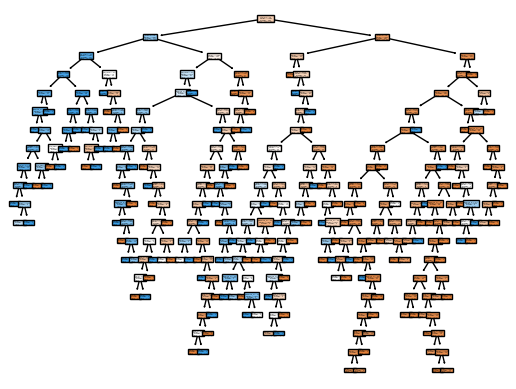

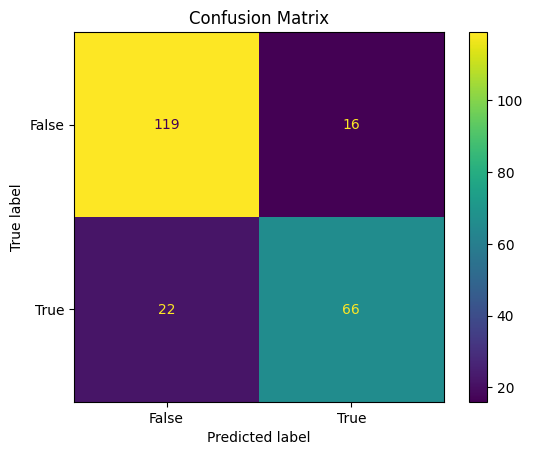

In [90]:
#Constructing Decision Tree
clf = tree.DecisionTreeClassifier(criterion = "entropy")
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf, filled = True, feature_names=X_train.columns)

#Calculating accuracy
y_tree = clf.predict(X_test)
accuracy = accuracy_score(y_tree, y_test)
print(f"Accuracy obtained for decision tree: {round(100*accuracy, 2)}%")

#Display of Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_tree, labels = clf.classes_), display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

## Decision tree with some parameters

Accuracy obtained for decision tree: 87.44%


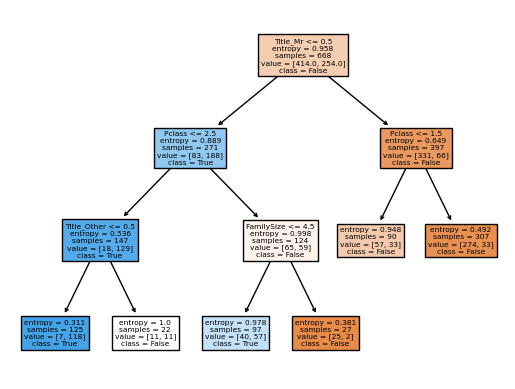

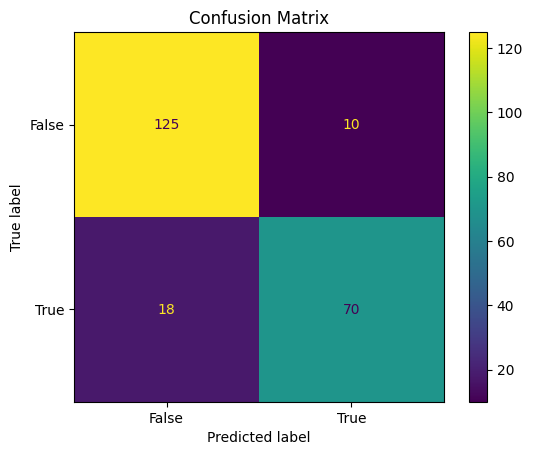

In [91]:
#Constructing Decision Tree
clf = tree.DecisionTreeClassifier(criterion="entropy", 
    min_samples_split=25, 
    min_samples_leaf=5, 
    ccp_alpha=0.01,
    max_depth = 5
    )
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf, filled = True, feature_names=X_train.columns, class_names=['False', 'True'])

#Calculating accuracy
y_tree = clf.predict(X_test)
accuracy = accuracy_score(y_tree, y_test)
print(f"Accuracy obtained for decision tree: {round(100*accuracy, 2)}%")

#Display of Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_tree, labels = clf.classes_), display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

## Choosing parameters to obtain best accuracy

**1. Finding most suitable parameters (min_sample_split, min_samples_leaf, ccp_alpha, max_depth)**

In [92]:
mss = 0
msl = 0
ccp = 0
md = 0
acc_best = 0

for i in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    for j in range(1,11):
        for k in range(1,6):
            for l in range(1, 15):
                clf = tree.DecisionTreeClassifier(criterion="entropy", 
                    min_samples_split=i, 
                    min_samples_leaf=j, 
                    ccp_alpha=k*0.01,
                    max_depth = l
                    )
                clf = clf.fit(X_train, y_train)
                y_tree = clf.predict(X_test)
                accuracy = accuracy_score(y_tree, y_test)
                if (accuracy > acc_best):
                    acc_best = accuracy
                    mss = i
                    msl = j
                    ccp = k*0.01
                    md = l
print(f"min sample split: {mss}, min samples leaf: {msl}, ccp alpha: {ccp}, max depth: {md}")

min sample split: 2, min samples leaf: 1, ccp alpha: 0.01, max depth: 4


**2. Plotting and evaluating tree**

Accuracy obtained for decision tree: 86.1%


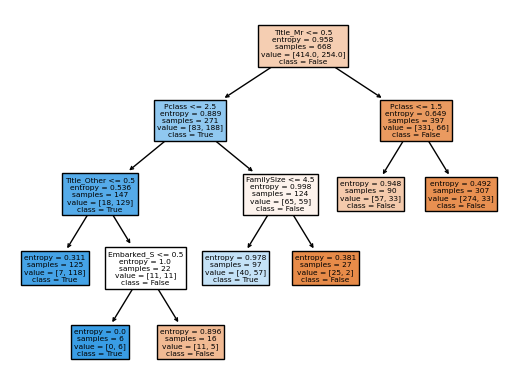

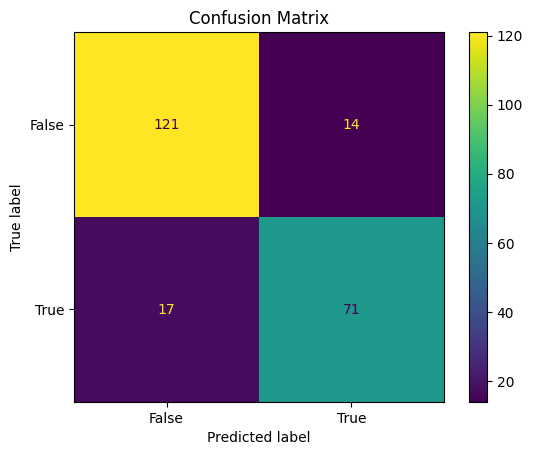

In [93]:
#Constructing Decision Tree
clf = tree.DecisionTreeClassifier(criterion="entropy", 
    min_samples_split=mss, 
    min_samples_leaf=msl, 
    ccp_alpha=ccp,
    max_depth = md
    )
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf, filled = True, feature_names=X_train.columns, class_names=['False', 'True'])

#Calculating accuracy
y_tree = clf.predict(X_test)
accuracy = accuracy_score(y_tree, y_test)
print(f"Accuracy obtained for decision tree: {round(100*accuracy, 2)}%")

#Display of Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_tree, labels = clf.classes_), display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

**3. Finding best parameters (min_samples_split, min_samples_leaf, max_depth, no cost complexity prunning)**

In [94]:
mss = 0
msl = 0
md = 0
acc_best = 0

for i in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    for j in range(1,11):
        for l in range(1, 15):
            clf = tree.DecisionTreeClassifier(criterion="entropy", 
                min_samples_split=i, 
                min_samples_leaf=j, 
                max_depth = l
            )
            clf = clf.fit(X_train, y_train)
            y_tree = clf.predict(X_test)
            accuracy = accuracy_score(y_tree, y_test)
            if (accuracy > acc_best):
                acc_best = accuracy
                mss = i
                msl = j
                md = l
print(f"min sample split: {mss}, min samples leaf: {msl}, max depth: {md}")

min sample split: 2, min samples leaf: 1, max depth: 4


**4. Plotting and evaluating tree (without cost complexity prunning)**

Accuracy obtained for decision tree: 88.34%


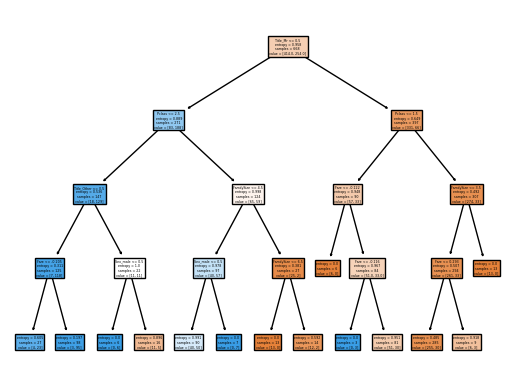

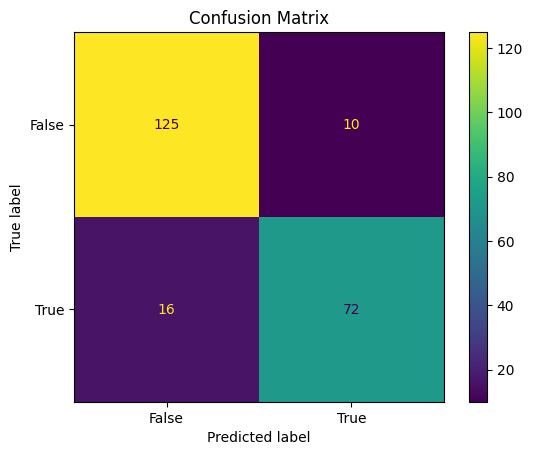

In [95]:
#Constructing Decision Tree
clf = tree.DecisionTreeClassifier(criterion="entropy", 
    min_samples_split=mss, 
    min_samples_leaf=msl, 
    max_depth = md
    )
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf, filled = True, feature_names=X_train.columns)

#Calculating accuracy
y_tree = clf.predict(X_test)
accuracy = accuracy_score(y_tree, y_test)
print(f"Accuracy obtained for decision tree: {round(100*accuracy, 2)}%")

#Display of Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_tree, labels = clf.classes_), display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

**5. What if we assign too high ccp_alpha parameter?**

Accuracy obtained for decision tree: 79.82%


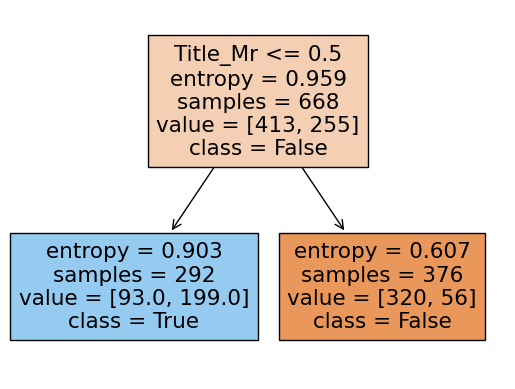

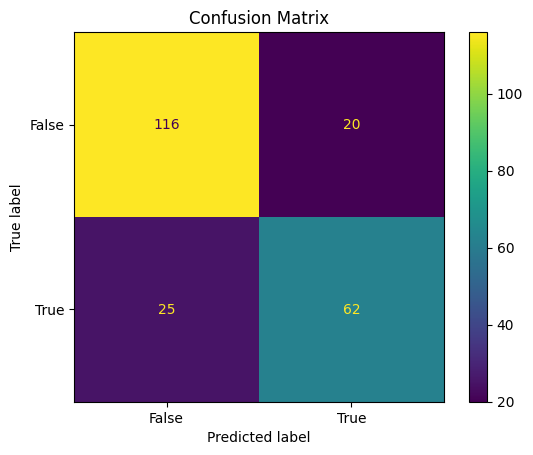

In [96]:
#Constructing Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
clf = tree.DecisionTreeClassifier(criterion="entropy", 
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_depth = 4,
    ccp_alpha = 0.1
    )
clf = clf.fit(X_train, y_train)

#Calculating accuracy
tree.plot_tree(clf, filled = True, feature_names=X_train.columns, class_names=['False', 'True'])
y_tree = clf.predict(X_test)
accuracy = accuracy_score(y_tree, y_test)
print(f"Accuracy obtained for decision tree: {round(100*accuracy, 2)}%")

#Display of Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_tree, labels = clf.classes_), display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Below cell was used to calculate averages (of trees with default and custom parameters; its not very important)

In [17]:
accuracies1 = []
accuracies2 = []

for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    #print(i)
    clf = tree.DecisionTreeClassifier(criterion="entropy")
    clf = clf.fit(X_train, y_train)
    y_tree = clf.predict(X_test)
    accuracy = accuracy_score(y_tree, y_test)
    accuracies1.append(accuracy)

    clf = tree.DecisionTreeClassifier(criterion="entropy",
        min_samples_split=25, 
        min_samples_leaf=5, 
        ccp_alpha=0.01,
        max_depth = 5
    )
    clf = clf.fit(X_train, y_train)
    y_tree = clf.predict(X_test)
    accuracy = accuracy_score(y_tree, y_test)
    accuracies2.append(accuracy)
#print(f"Accuracy obtained for default decision tree: {round(100*mean(accuracies1), 2)}%")
#print(f"Accuracy obtained for custom decision tree: {round(100*mean(accuracies2), 2)}%")